In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
from scipy import ndimage
from torch.autograd.functional import jacobian

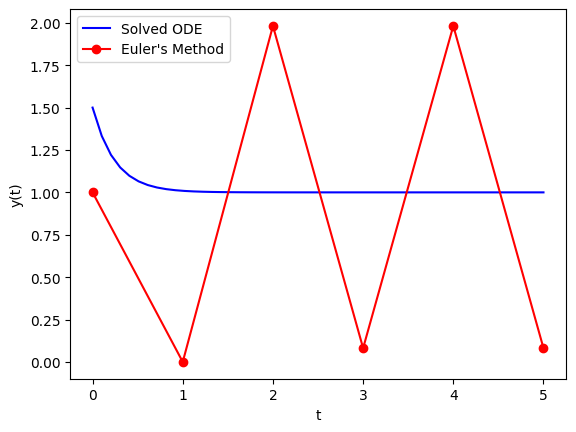

In [14]:
#plotting the Eulers method vs Solved ODE
x_points_euler= [0,1,2,3,4,5]
y_points_euler = [1,0,1.9817, 0.0813, 1.9817, 0.0813]

def f(t):
    return 1 + (np.exp(-4 * t) / 2)

t = np.linspace(0,5)

plt.plot(t, f(t), color="blue", label="Solved ODE")
plt.plot(x_points_euler, y_points_euler, color="red", label="Euler's Method", marker='o')
plt.xlabel("t")
plt.ylabel("y(t)")
plt.title("Closed Form ODE vs. Eulers Approximation")
plt.legend()
plt.show()


Plotting w/ Different Step Size 

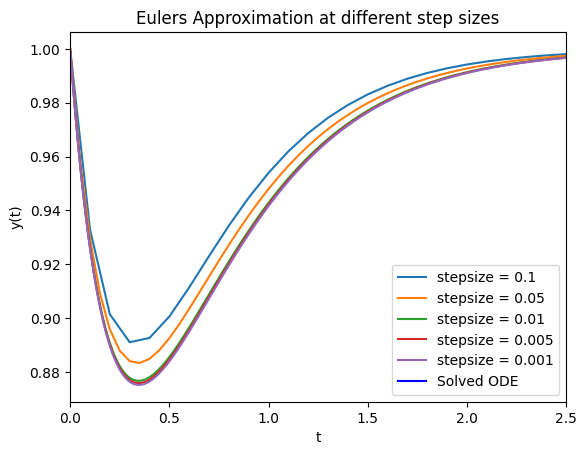

In [37]:
def ode(y ,t):
    return (-2*y) + 2 - np.exp(-4*t)
 
def eulers_formula(y_prev,stepsize,t):
    return y_prev + stepsize* ode(y_prev, t)


def eulers_approximation(h = [0.1,0.05, 0.01, 0.005, 0.001]):
    y_init = 1

    for step_size in h:
        y = y_init
        eulers_y_values = []
        t_values = np.arange(0, 5+step_size,step_size)
        eulers_y_values.append(y)


        for t in t_values[1:]:
            y = eulers_formula(y,step_size, t)
            eulers_y_values.append(y)

        plt.plot(t_values, eulers_y_values, label =f"stepsize = {step_size}")



    plt.plot(t, f(t), color="blue", label="Solved ODE")
    plt.title("Eulers Approximation at different step sizes")
    plt.xlabel("t")
    plt.ylabel("y(t)")
    plt.xlim(0,2.5)
    plt.legend()
    plt.show()
        
eulers_approximation()
            

2a)


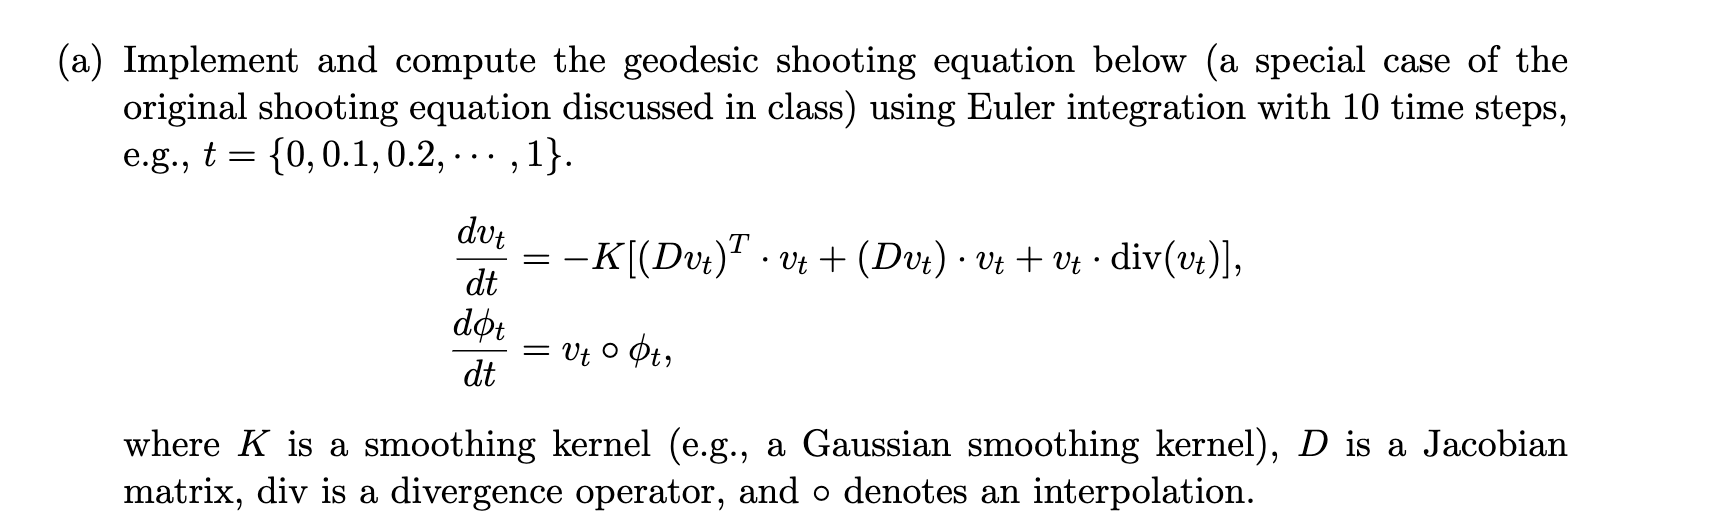

In [75]:


def forward_difference_x(image):
    rows, cols = image.shape
    d = np.zeros((rows,cols))
    d[:,1:cols-1] = image[:,1:cols-1] - image[:,0:cols-2];
    d[:,0] = image[:,0] - image[:,cols-1];
    return d


def forward_difference_y(image):
    rows, cols = image.shape
    d = np.zeros((rows,cols))
    d[1:rows-1,:] = image[1:rows-1,:] - image[0:rows-2,:];
    d[0,:] = image[0,:] - image[rows-1,:];
    return d

def divergence(vT):
    Fx = vT[0]
    Fy = vT[1]

    dFx = forward_difference_x(Fx)
    dFy = forward_difference_y(Fy)

    return dFx+dFy

def compute_jacobian(vt):
    return jacobian(lambda x:x, vt)


def dTs(vt,ts ):
    return ndimage.map_coordinates([vt,ts], order = 3)


def dVt(vt):
    # Use PyTorch to compute Jacobian and other terms
    J = compute_jacobian(vt)
    inner_term = torch.transpose(J, 0, 1) * vt + (J * vt + vt * divergence(vt))
    return -1 *ndimage.gaussian_filter(inner_term, sigma = 1)


def geodesic_shooting():
    dt = 0.1
    t_steps = torch.arange(0,1,dt)
    
    #loading data
    v0  = torch.load("PS2_Q2/code+data/v0.pt")
    source = torch.load("PS2_Q2/code+data/source.pt")
    ts_init  = np.meshgrid(source)

    v = v0
    ts = ts_init

    for t in t_steps:
        dv = dVt(v)
        v = v + dt*dv #eulers formula

        ts = torch.tensor(ndimage.map_coordinates(ts, v))

    return v, ts

v , ts = geodesic_shooting()

RuntimeError: The size of tensor a (2) must match the size of tensor b (100) at non-singleton dimension 1